# Random Forest Example - simplified from its original

Used and further adapted by: Elizabeth Barnes in ATS 655 at Colorado State University

Original created by: Aaron Hill and Wei-Ting Hsiao (Dept. of Atmospheric Science, Colorado State University), January 2020

Example adapted from Will Koehrsen: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

***

Lets import some libraries we will need throughout this tutorial:



In [1]:
# Pandas is used for data manipulation
import pandas as pd

# Use numpy to convert to arrays
import numpy as np

# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Time formatter
import datetime

# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
import matplotlib.pyplot as plt
%matplotlib inline

# Permutation importance method from sklearn
from sklearn.inspection import permutation_importance

# specify whether running on Colab or locally
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
print('IN_COLAB = ' + str(IN_COLAB))

IN_COLAB = False


In [2]:
# Predefined functions for later use

def plot_time_series(features, feature_list, labels, val_features, predictions):
    
    # Use datetime for creating date objects for plotting
    # Dates of training values
    months = features[:, feature_list.index('MONTH')]
    days = features[:, feature_list.index('DAY')]
    years = features[:, feature_list.index('YEAR')]
    
    # List and then convert to datetime object
    dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
    dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]
    
    # Dataframe with true values and dates
    true_data = pd.DataFrame(data = {'date': dates, 'TMAX': labels})
    
    # Dates of predictions
    months = val_features[:, feature_list.index('MONTH')]
    days = val_features[:, feature_list.index('DAY')]
    years = val_features[:, feature_list.index('YEAR')]
    
    # Column of dates
    test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
    
    # Convert to datetime objects
    test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]
    
    # Dataframe with predictions and dates
    predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predictions})
    
    #------------------------------------------------
    # plot the predictions
    plt.plot(true_data['date'], true_data['TMAX'], 'b-', label = 'actual TMAX')
    plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction of validation set')
    plt.xticks(rotation = '60'); 
    plt.legend()
    plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual and Predicted Values');

# 1. Data Preparation

### 1.1 Data overview

We have stored a .csv file on a CSU drive, accessible via URL. This will be the basis for our tutorial. This file contains Fort Collins weather data from 2018, and we will use these data to predict the high temperature for a given day with a random forest regression model.  

In [3]:
# Read in data from url
url = "http://schumacher.atmos.colostate.edu/hilla/temps_FC.csv"
features = pd.read_csv(url)
features = features.drop('TMAX_BD', axis = 1)

Lets look at our data to see what we are working with

In [4]:
# Display first 5 rows
print('The shape of our features is:', features.shape)
features.head(5)

The shape of our features is: (365, 10)


,YEAR,MONTH,DAY,TMAX,TMIN,TMAX_1d,TMAX_2d,TMAX_SF,PRCP,TMAX_CLIM
0,2018,1,1,26,10,31,24,61,0.0,43.5
1,2018,1,2,41,5,26,31,61,0.0,43.6
2,2018,1,3,47,12,41,26,58,0.0,43.7
3,2018,1,4,51,18,47,41,63,0.0,43.8
4,2018,1,5,50,21,51,47,61,0.0,43.9


You will notice we have 365 days of features and labels (complete set from 2018). Our second features axis is the columns of the pandas dataframe. These columns represent the year, month, day, maximum temperature, minimum temperature, max temp from day before, max temp from two days prior, max temperature in San Francisco, precipitation, and climatological maximum. 

The max temperature column (TMAX) is actually our label: the observed max temperature at Fort Collins.

We can look quickly at some basic statistics of our data, such as mean, standard deviation, percentiles, etc. in a table format

In [5]:
# A handy tool in pandas: descriptive statistics for each column
features.describe()

,YEAR,MONTH,DAY,TMAX,TMIN,TMAX_1d,TMAX_2d,TMAX_SF,PRCP,TMAX_CLIM
count,365.0,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,2018.0,6.526027,15.720548,65.652055,37.389041,65.627397,65.564384,63.904110,0.037260,63.738356
std,0.0,3.452584,8.808321,18.372280,16.232409,18.412798,18.515789,6.004038,0.147239,15.407528
min,2018.0,1.000000,1.000000,15.000000,-3.000000,15.000000,15.000000,51.000000,0.000000,42.100000
25%,2018.0,4.000000,8.000000,50.000000,24.000000,50.000000,50.000000,60.000000,0.000000,48.100000
50%,2018.0,7.000000,16.000000,65.000000,37.000000,65.000000,65.000000,63.000000,0.000000,63.000000
75%,2018.0,10.000000,23.000000,82.000000,52.000000,82.000000,82.000000,67.000000,0.000000,78.500000
max,2018.0,12.000000,31.000000,101.000000,68.000000,101.000000,101.000000,83.000000,1.740000,87.100000


We have made it so that there is not much to clean up in this dataset...however you may run into a scenario where days are missing, values are missing, etc. wherein you need to remove bad features, labels, or examples (i.e., days of observations). It is often said that 80% of machine learning is the preprocessing of your data. 


### 1.2 Targets and features

The pandas table is handy for a quick glance, but we need to organize some numpy arrays that separately contain our features and labels.

In [6]:
# Labels are the values we want to predict
labels = np.array(features['TMAX'])

# Remove the labels from the features
# axis 1 refers to the columns
features = features.drop('TMAX', axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

### 1.3 Splitting training and testing datasets

Assuming we have no feature data available from 2019 we could use to test our trained models against, we will want to split up our dataset into training and testing portions. A standard proportion is 3/4 for training, 1/4 for testing, although this is somewhat arbitrary here. 

In [7]:
# Split the data into training, validation and testing sets

# Tunable Parameter "split_size": Describes the proportion of the dataset we want to use for 
#      testing/training/validation. 
#      do not modify.
split_size = 0.2    

# PARAMETERS:
#     test_size: fraction of testing/validation datasets
#     random_state: random parameter
#     do not modify.
# train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = split_size, random_state = 42)
# val_features, test_features, val_labels, test_labels     = train_test_split(test_features, test_labels, test_size = .5, random_state = 42)

i = np.where(np.isin(features[:,1],(2,11))==False)[0]
train_features = features[i,:]
train_labels = labels[i]
train_features, val_features, train_labels, val_labels = train_test_split(train_features, train_labels, test_size = split_size, random_state = 42)

i = np.where(np.isin(features[:,1],(2,11))==True)[0]
test_features = features[i,:]
test_labels = labels[i]

Lets quickly check the size of our training and testing arrays are what we expect (and we didn't do something wrong)

In [8]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Validation Features Shape:', val_features.shape)
print('Validation Labels Shape:', val_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (245, 9)
Training Labels Shape: (245,)
Validation Features Shape: (62, 9)
Validation Labels Shape: (62,)
Testing Features Shape: (58, 9)
Testing Labels Shape: (58,)


# 2. Playing with model

OK, our data is now split up into features and labels, as well as training and testing chunks. Now we will work to train and evaluate our model.

First, we need to know what our baseline skill is. Often, climatology is used and we will do just that, taking the climatological high temperature from the test features and evaluating it against the test labels

### 2.1 Establish Baseline


--------------------------------------------
Validation Baseline error (MAE):  8.09
--------------------------------------------



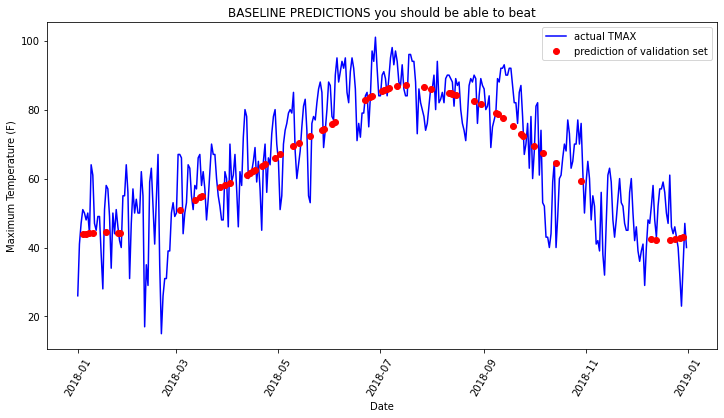

In [9]:
# You need a baseline to quantify whether the model is useful

# The baseline predictions here are the climatological values
# Grab all rows for the 'TMAX_CLIM' column
baseline_preds = val_features[:, feature_list.index('TMAX_CLIM')]

# Baseline errors (mean absolute errors)
mae_baseline_errors = abs(baseline_preds - val_labels)
print('\n--------------------------------------------')
print('Validation Baseline error (MAE): ', round(np.mean(mae_baseline_errors), 2))
print('--------------------------------------------\n')

# -------------------------------
# Visualize the baseline

# plot the figure
plt.figure(figsize=(12,6))
plot_time_series(features, feature_list, labels, val_features, baseline_preds)
plt.title('BASELINE PREDICTIONS you should be able to beat')
plt.show()

Subjectively, these errors seem quite high, but as one might expect when trying to predict high temperatures from climatology. I think we can improve upon this with a RF model

### 2.2 Train model

As mentioned in the slides, there are a number of hyperparameters for RF models that we can tweak and tune to make the model perform better. We will start with a base set of hyperparameters that are defaults for the RF regression model in scikit-learn. 

In [10]:
#----------------------------------------------------------------------------------------
# MODIFY: important tunable parameters for model
number_of_trees = 3  # number of trees to "average" together to create a random forest
tree_depth = 2       # maximum depth allowed for each tree
node_split = 2       # minimum number of training samples needed to split a node
leaf_samples = 1     # minimum number of training samples required to make a leaf node
criterion = 'mae'    # variance reduction, alternatively 'mse'
bootstrap = True     # whether to perform "bagging=bootstrap aggregating" or not
max_samples = None   # number of samples to grab when training each tree IF bootstrap=True
RAND_STATE = 42
#----------------------------------------------------------------------------------------

# Instantiate model with number of decision trees prescribed above
# PARAMETERS:
#     n_estimators: number of trees/ensemble members
#     random_state: random seed
#     max_depth: maximum depth of each tree
#     criterion: evaluation statistic to split a mode, 'mse'  or 'mae'
#     min_samples_split: minimum number of samples needed to split a node
#     min_samples_leaf: minimum number of samples needed to make a leaf
#     for more, see: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor
rf = RandomForestRegressor(n_estimators = number_of_trees, 
                           random_state = RAND_STATE,
                           min_samples_split = node_split,
                           min_samples_leaf = leaf_samples,
                           criterion = criterion,
                           max_depth = tree_depth)

# Train the model on training data
rf.fit(train_features, train_labels)

RandomForestRegressor(criterion='mae', max_depth=2, n_estimators=3,
                      random_state=42)

Just a handful of lines of code to train the model. Easy peasy. Now lets make some predictions from our model

### 2.3 Make predictions and visualize the performance


--------------------------------------------
    Actual Training Error (MAE):  5.88
  Actual Validation Error (MAE):  8.45
Validation Baseline error (MAE):  8.09
--------------------------------------------



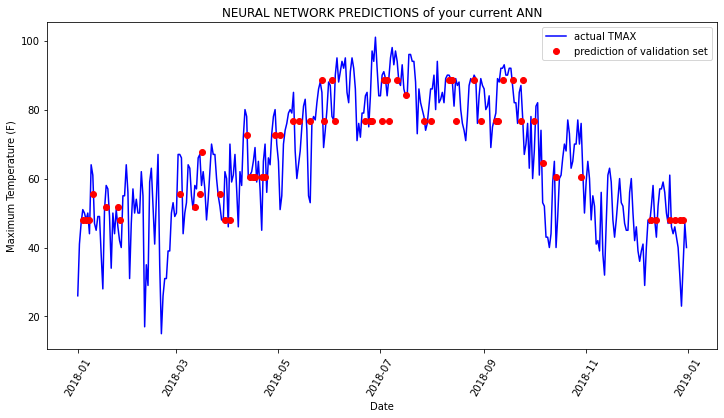

In [11]:
# Use the model to predict the validation set
predictions = rf.predict(val_features)
predictions_train = rf.predict(train_features)

# Use the validation set to validate the performance
# Print out the mean absolute error (MAE)
mae_errors = abs(predictions - val_labels)
mae_errors_train = abs(predictions_train - train_labels)

print('\n--------------------------------------------')
print('    Actual Training Error (MAE): ', round(np.mean(mae_errors_train), 2))
print('  Actual Validation Error (MAE): ', round(np.mean(mae_errors), 2))
print('Validation Baseline error (MAE): ', round(np.mean(mae_baseline_errors), 2))
print('--------------------------------------------\n')

# -------------------------------
# Visualize the predictions

# make the predictions
predictions = rf.predict(val_features)

# plot the figure
plt.figure(figsize=(12,6))
plot_time_series(features, feature_list, labels, val_features, predictions)
plt.title('NEURAL NETWORK PREDICTIONS of your current ANN')
plt.show()

In [12]:
# # -------------------------------
# # DO NOT UNCOMMENT THIS CELL OR YOU WILL BE CHEATING
# # -------------------------------

# # Use the model to predict the test data
# predictions = rf.predict(test_features)

# # Use testing set to validate the performance
# # Print out the mean absolute error (MAE)
# mae_errors = abs(predictions - test_labels)
# print('\n******************')
# print('Testing Error (MAE): ', round(np.mean(mae_errors), 2))
# print('******************\n')

# # plot the figure
# plt.figure(figsize=(12,6))
# plot_time_series(features, feature_list, labels, test_features, predictions)
# plt.title('TESTING RESULTS')
# plt.show()

# VISUALIZATION TECHNIQUES

### 3.2 Feature Importances

First we will look at Impurity Importance, which is built into Scikit-learn. 

In [13]:
def calc_importances(rf, feature_list):

    # Get numerical feature importances
    importances = list(rf.feature_importances_)

    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

    # Print out the feature and importances 
    print('')
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];
    print('')
    
    return importances

In [14]:
def plot_feat_importances(importances, feature_list): 
    plt.figure()
    # Set the style
    plt.style.use('fivethirtyeight')
    # list of x locations for plotting
    x_values = list(range(len(importances)))
    # Make a bar chart
    plt.barh(x_values, importances)
    # Tick labels for x axis
    plt.yticks(x_values, feature_list)
    # Axis labels and title
    plt.xlabel('Importance'); plt.ylabel('Variable'); plt.title('Variable Importances')


Variable: TMIN                 Importance: 0.49
Variable: TMAX_CLIM            Importance: 0.3
Variable: TMAX_1d              Importance: 0.21
Variable: YEAR                 Importance: 0.0
Variable: MONTH                Importance: 0.0
Variable: DAY                  Importance: 0.0
Variable: TMAX_2d              Importance: 0.0
Variable: TMAX_SF              Importance: 0.0
Variable: PRCP                 Importance: 0.0



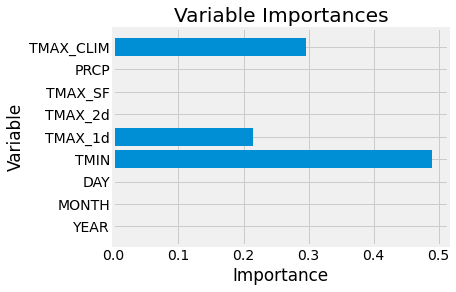

In [15]:
plot_feat_importances(calc_importances(rf, feature_list), feature_list)

### 3.3 Permutation Importances

In [16]:
# Single-pass permutation
permute = permutation_importance(rf, val_features, val_labels, n_repeats=10, 
                                 random_state=RAND_STATE)

# Sort the importances
sorted_idx = permute.importances_mean.argsort()

First, lets look at what is most important in the validation set

In [17]:
def plot_perm_importances(permute, sorted_idx, feature_list):
    # Sort the feature list based on 
    
    new_feature_list = []
    for index in sorted_idx:  
        new_feature_list.append(feature_list[index])

    fig, ax = plt.subplots()
    ax.boxplot(permute.importances[sorted_idx].T,
           vert=False, labels=new_feature_list)
    ax.set_title("Permutation Importances")
    fig.tight_layout()

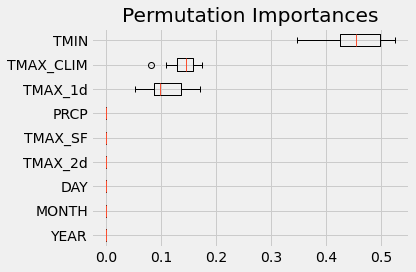

In [18]:
plot_perm_importances(permute, sorted_idx, feature_list)

### Save the random forest architecture to png in your Google Drive

Visualizing a Single Decision Tree

In [19]:
# Make the path of your own Google Drive accessible to save a figure
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    local_path = '/content/drive/My Drive'
else:
    local_path = 'figures/'

In [20]:
fig_savename = 'TMAX_tree'
tree = rf[-1]

export_graphviz(tree,
                out_file=local_path + '/' + fig_savename+'.dot',
                filled=True,
                proportion=False,
                rounded=True,
                leaves_parallel=False,
                feature_names=feature_list)

# Use dot file to create a graph to write to a png
(graph, ) = pydot.graph_from_dot_file(local_path + '/' + fig_savename + '.dot')
graph.write_png(local_path + '/' + fig_savename + '.png')


![Decision Tree](/content/drive/My Drive/TMAX_tree.png)